##Model Training
Several models were trained and evaluated using the Root Mean Squared Error (RMSE) metric. A TimeSeriesSplit cross-validation strategy was used where applicable to account for the temporal nature of the data.

###Linear Regression
Linear Regression was used as a baseline model. Due to the complex and nonlinear relationships between stock prices and macroeconomic indicators, Linear Regression did not perform well. However, its role is valuable as a benchmark — any model that outperforms it demonstrates added predictive value.

###Random Forest
Random Forest outperformed Linear Regression when evaluated using time series cross-validation. Its ability to model nonlinear relationships and interactions between features made it a better fit for the task.

###XGBoost
XGBoost achieved the best performance among all models. It consistently outperformed Linear Regression and Random Forest during time series cross-validation.

###LSTM Neural Network
The LSTM model tended to overfit due to the limited size of the dataset, even with a small number of training epochs. As a result, its performance on the test set was not competitive.

###ARIMA Model
An ARIMAX model was used to incorporate macroeconomic variables. Despite this, the model yielded the worst performance among all tested models, suggesting that traditional statistical methods are less effective in this context compared to machine learning models.

#Model Testing and Final Conclusion
XGBoost was selected as the final model due to its superior performance. It outperformed Linear Regression, making it the most suitable choice for predicting the GDAXI index using macroeconomic indicators but still the result is not consistent enough for practical usage

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from statsmodels.tsa.arima.model import ARIMA
from keras.losses import Huber
import joblib

In [2]:
RANDOMSTATE = 1234
#link to GitHub repo where stock price is saved
TARGET_TRAIN_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/target_train.csv'
TARGET_TRAIN_FILE_NAME = 'target_train.csv'
TARGET_TEST_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/target_test.csv'
TARGET_TEST_FILE_NAME = 'target_test.csv'
##link to GitHub repo where macroeconomics indicators are saved
FEATURE_TRAIN_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/features_train.csv'
FEATURE_TRAIN_FILE_NAME = 'features_train.csv'
FEATURE_TEST_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/features_test.csv'
FEATURE_TEST_FILE_NAME = 'features_test.csv'
##link to GitHub repo where scalers are saved
SCALER_TARGET_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/scaler_target.save'
SCALER_TARGET_FILE_NAME = 'scaler_target.save'
SCALER_FEATURES_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/scaler_features.save'
SCALER_FEATURES_FILE_NAME = 'scaler_features.save'

In [3]:
#geting data from url and saves it locally
def get_data(url, file_name):
  response = requests.get(url)

#Check if the request was successful
  if response.status_code == 200:
      # Save the file locally
      with open(file_name, "wb") as file:
          file.write(response.content)
      print(f"File downloaded successfully: {file_name}")
      return file_name
  else:
    print(f"Failed to download file: {file_name} Status code: {response.status_code}")
    return None

In [4]:
#function training model using GridSearchCV
def model_training (model, grid_space, features_train, target_train, cv):

#pipline to scale data before every cross validation iteration
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])

#Apply pipline for parameter iteration function
    grid = GridSearchCV(pipeline, param_grid=grid_space, cv=cv, scoring='neg_root_mean_squared_error')
    model_grid = grid.fit(features_train, target_train)
    best_model = grid.best_estimator_

    print('The model with the best parameters: '+str(model_grid.best_params_))
#multiply negative root mean squared error by -1 to avoid confusion
    print('The best result (RMSE): '+str(model_grid.best_score_*-1))
    return best_model

In [5]:
#Download preprocessed data from GitHub
get_data(TARGET_TRAIN_URL, TARGET_TRAIN_FILE_NAME)
get_data(TARGET_TEST_URL, TARGET_TEST_FILE_NAME)
get_data(FEATURE_TRAIN_URL, FEATURE_TRAIN_FILE_NAME)
get_data(FEATURE_TEST_URL, FEATURE_TEST_FILE_NAME)
get_data(SCALER_TARGET_URL, SCALER_TARGET_FILE_NAME)
get_data(SCALER_FEATURES_URL, SCALER_FEATURES_FILE_NAME)

File downloaded successfully: target_train.csv
File downloaded successfully: target_test.csv
File downloaded successfully: features_train.csv
File downloaded successfully: features_test.csv
File downloaded successfully: scaler_target.save
File downloaded successfully: scaler_features.save


'scaler_features.save'

In [6]:
target_train = pd.read_csv('target_train.csv')
target_test = pd.read_csv('target_test.csv')
features_train = pd.read_csv('features_train.csv')
features_test = pd.read_csv('features_test.csv')
scaler_target = joblib.load('scaler_target.save')
scaler_features = joblib.load('scaler_features.save')

In [7]:
target_train.set_index('date', inplace=True)
target_test.set_index('date', inplace=True)
features_train.set_index('date', inplace=True)
features_test.set_index('date', inplace=True)

#Model Training

In [8]:
#create timeseries split for crossvalidation
tscv = TimeSeriesSplit(n_splits=5)

##Linear Regression

In [9]:
model_line = LinearRegression()

scores_line  = cross_val_score(model_line, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)
final_score_line = scores_line.mean()

# grid search results
print('The best result (RMSE): ', final_score_line*-1)

The best result (RMSE):  0.9454199461844691


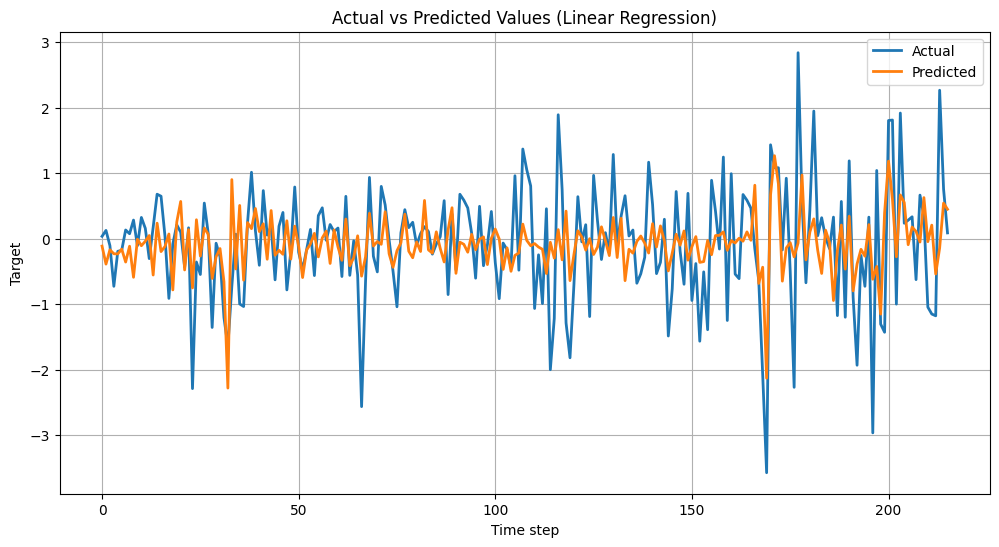

In [10]:
model_line.fit(features_train, target_train)
pred_line = model_line.predict(features_train)

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_line, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

In [11]:
{
            'model__max_depth':[1,2],
            'model__n_estimators':[10,100],
            'model__min_samples_leaf':[2, 3],
            'model__min_samples_split':[2, 3, 4],
            'model__max_features': [None, 'sqrt', 'log2'],
            'model__ccp_alpha': [0.1, 0.2]

           }

{'model__max_depth': [1, 2],
 'model__n_estimators': [10, 100],
 'model__min_samples_leaf': [2, 3],
 'model__min_samples_split': [2, 3, 4],
 'model__max_features': [None, 'sqrt', 'log2'],
 'model__ccp_alpha': [0.1, 0.2]}

In [12]:
grid_space_forest={
            'model__max_depth':[10, 20],
            'model__n_estimators':[100, 1000],
            'model__min_samples_leaf':[2, 3, 5],
            'model__min_samples_split':[2, 3, 4, 5],
            'model__max_features': [None, 'sqrt', 'log2']
#            'model__ccp_alpha': [0.1, 0.2]

           }
#use previously created function
print('Starting model training...')
model_forest = model_training (RandomForestRegressor(random_state=RANDOMSTATE),
                        grid_space_forest, features_train, target_train.values.ravel(), tscv)

Starting model training...
The model with the best parameters: {'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 1000}
The best result (RMSE): 0.8544574963271909


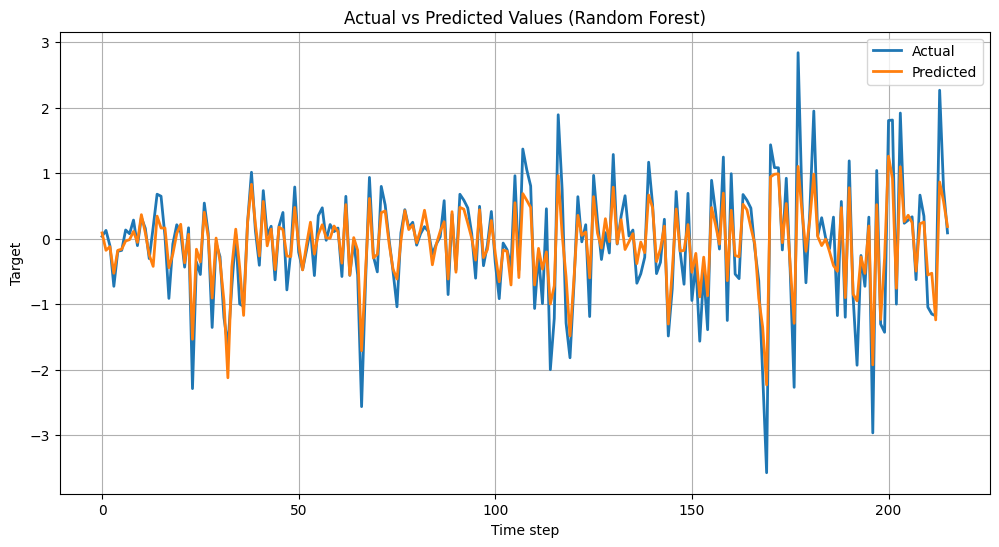

In [13]:
pred_forest = model_forest.predict(features_train)

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_forest, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (Random Forest)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

##XGB Regressor

In [14]:
grid_space_xgb = {
    'model__max_depth': [None, 15, 20],
    'model__learning_rate': [0.01],
    'model__n_estimators': [100],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0.1, 1, None],
    'model__reg_lambda': [0.1, 1, None]
}
#use previously created function
model_xgb = model_training (xgb.XGBRegressor(n_estimators=100, learning_rate=0.1), grid_space_xgb, features_train, target_train, cv = tscv)

The model with the best parameters: {'model__colsample_bytree': 1.0, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': None, 'model__n_estimators': 100, 'model__reg_alpha': None, 'model__reg_lambda': 1, 'model__subsample': 1.0}
The best result (RMSE): 0.8531039476394653


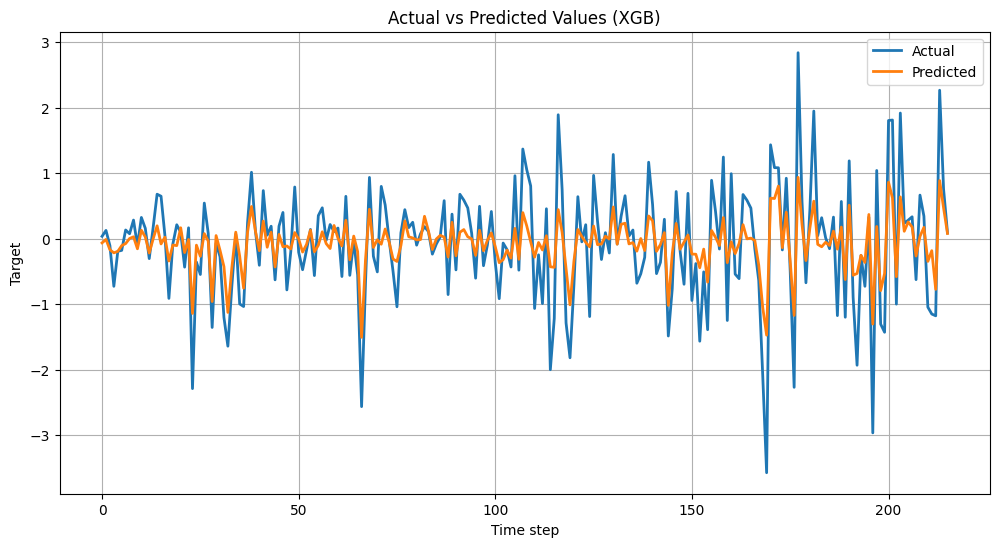

In [15]:
pred_xgb = model_xgb.predict(features_train)

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_xgb, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (XGB)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

##LSTM Neural Network

Creating window for a memory

In [103]:
def create_sequences(features, target, window_size, prepend_features=None, prepend_target=None):
    """
    Create sliding window sequences.
    If prepend_features/target are provided, they will be used to pad the beginning.
    """
    if prepend_features is not None:
        features = pd.concat([prepend_features, features], ignore_index=True)
    if prepend_target is not None:
        target = pd.concat([prepend_target, target], ignore_index=True)

    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i + window_size].values)
        y.append(target.iloc[i + window_size].values)
    return np.array(X), np.array(y)

window_size = 12

# Training sequences
scaled_features_train_win, scaled_target_train_win = create_sequences(features_train, target_train, window_size)

# For test sequences, prepend last 12 values from train
scaled_features_test_win, scaled_target_test_win = create_sequences(
    features_test, target_test,
    window_size,
    prepend_features=features_train.iloc[-window_size:],
    prepend_target=target_train.iloc[-window_size:]
)
target_train_sliced = target_train[window_size:]

print("Train shape:", scaled_features_train_win.shape)
print("Test shape:", scaled_features_test_win.shape)


Train shape: (204, 12, 10)
Test shape: (14, 12, 10)


###LSTM 5 LAYERS

Compile model arhitecture

In [122]:
# create and compile the LSTM network
model = Sequential([
    LSTM(500,
           return_sequences=True,
            input_shape=(window_size, scaled_features_train_win.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(50, return_sequences=False),  # Last LSTM returns single sequence
    Dropout(0.1),
    Dense(16, activation='relu', kernel_regularizer=l2(1e-5)),  # Extra layer to boost capacity
    Dense(1, activation='linear', bias_initializer='zeros')
])

model.compile(optimizer='adam', loss=Huber(delta=1.0))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 12, 500)        │     1,022,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 12, 64)         │       144,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,190,473 (4.54 MB)

 Trainable params: 1,190,473 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

Create checkpoint to select the best fitted epoch

In [126]:
best_model_lstm_5 = ModelCheckpoint(
    filepath='best_model_lstm_5.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

Model training

In [127]:
model.fit(scaled_features_train_win,
          scaled_target_train_win,
          epochs=5,
          batch_size=4,
          verbose=2,
          validation_split=0.2,
          callbacks=[best_model_lstm_5])

Epoch 1/5
41/41 - 3s - 66ms/step - loss: 0.2843 - val_loss: 0.5978
Epoch 2/5
41/41 - 4s - 110ms/step - loss: 0.2815 - val_loss: 0.5960
Epoch 3/5
41/41 - 2s - 45ms/step - loss: 0.2818 - val_loss: 0.5962
Epoch 4/5
41/41 - 2s - 48ms/step - loss: 0.2811 - val_loss: 0.5963
Epoch 5/5
41/41 - 3s - 72ms/step - loss: 0.2807 - val_loss: 0.5964


Make a prediction and model evaluation

In [128]:
model_LSTM_5 = load_model('best_model_lstm_5.keras')
closing_price_LSTM_5 = model_LSTM_5.predict(scaled_features_train_win)

rmse_LSTM_5 = mean_squared_error(target_train_sliced, closing_price_LSTM_5)**0.5

print('The average root square error in the test sample was:', rmse_LSTM_5)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
The average root square error in the test sample was: 0.9148069757095506


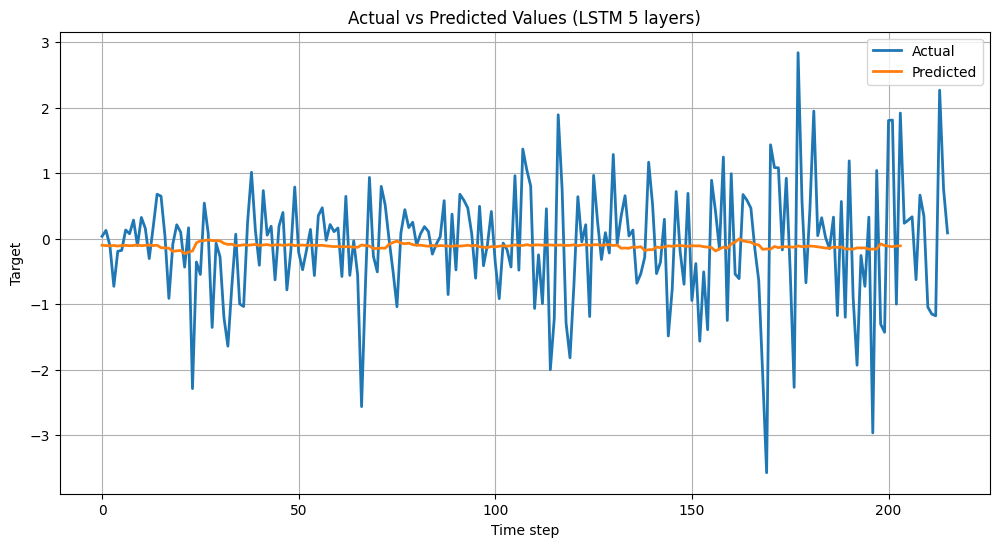

In [129]:
# Reshape pred_LSTM to match the shape of target_train.values for plotting
pred_LSTM_reshaped = closing_price_LSTM_5.reshape(-1, 1)

pred_aligned = np.empty_like(target_train.values)
pred_aligned[:] = np.nan
# Adjust the slicing to align the predicted values correctly
pred_aligned[window_size:] = pred_LSTM_reshaped

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_LSTM, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (LSTM 5 layers)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

###500 LSTM

In [130]:
# create and compile the LSTM network
model_LSTM_500 = Sequential([
    LSTM(500,
           return_sequences=False,
            input_shape=(window_size, scaled_features_train_win.shape[2])),
    Dense(1, activation='linear', bias_initializer='zeros')
])

model_LSTM_500.compile(optimizer='adam', loss=Huber(delta=1.0))
model_LSTM_500.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 500)            │     1,022,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,501 (3.90 MB)

 Trainable params: 1,022,501 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
checkpoint_LSTM_500 = ModelCheckpoint(
    filepath='best_model_lstm_500.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [115]:
model_LSTM_500.fit(scaled_features_train_win,
          scaled_target_train_win,
          epochs=10,
          batch_size=4,
          verbose=2,
          validation_split=0.2,
          callbacks=[checkpoint_LSTM_500])

Epoch 1/10
41/41 - 1s - 30ms/step - loss: 0.0910 - val_loss: 0.7841
Epoch 2/10
41/41 - 1s - 29ms/step - loss: 0.0703 - val_loss: 0.7126
Epoch 3/10
41/41 - 1s - 28ms/step - loss: 0.0763 - val_loss: 0.7305
Epoch 4/10
41/41 - 1s - 28ms/step - loss: 0.0552 - val_loss: 0.7504
Epoch 5/10
41/41 - 2s - 37ms/step - loss: 0.0463 - val_loss: 0.7496
Epoch 6/10
41/41 - 3s - 66ms/step - loss: 0.0342 - val_loss: 0.7121
Epoch 7/10
41/41 - 2s - 59ms/step - loss: 0.0250 - val_loss: 0.7554
Epoch 8/10
41/41 - 2s - 60ms/step - loss: 0.0213 - val_loss: 0.6969
Epoch 9/10
41/41 - 3s - 61ms/step - loss: 0.0140 - val_loss: 0.6983
Epoch 10/10
41/41 - 2s - 50ms/step - loss: 0.0122 - val_loss: 0.7259


In [116]:
model_LSTM_500 = load_model('best_model_lstm_500.keras')
closing_price_LSTM_500 = model_LSTM_500.predict(scaled_features_train_win)

rmse_LSTM_500 = mean_squared_error(target_train_sliced, closing_price_LSTM_500)**0.5

print('The average root square error in the test sample was:', rmse_LSTM_500)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
The average root square error in the test sample was: 0.6345527409321872


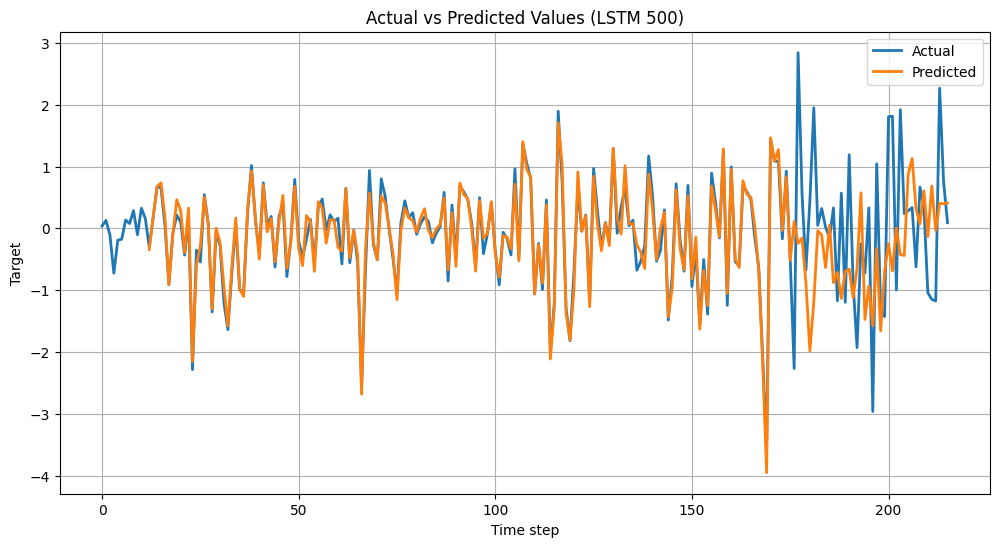

In [131]:
# Reshape pred_LSTM to match the shape of target_train.values for plotting
pred_LSTM_500_reshaped = closing_price_LSTM_500.reshape(-1, 1)

pred_aligned_LSTM_500 = np.empty_like(target_train.values)
pred_aligned_LSTM_500[:] = np.nan
# Adjust the slicing to align the predicted values correctly
pred_aligned_LSTM_500[window_size:] = pred_LSTM_500_reshaped

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_aligned_LSTM_500, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (LSTM 500)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

###200 LSTM

In [118]:
# create and compile the LSTM network
model_LSTM_200 = Sequential([
    LSTM(200,
           return_sequences=False,
            input_shape=(window_size, scaled_features_train_win.shape[2])),
    Dense(1, activation='linear', bias_initializer='zeros')
])

model_LSTM_200.compile(optimizer='adam', loss=Huber(delta=1.0))
model_LSTM_200.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 200)            │       168,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,001 (660.16 KB)

 Trainable params: 169,001 (660.16 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
checkpoint_LSTM_200 = ModelCheckpoint(
    filepath='best_model_lstm_200.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [81]:
model_LSTM_200.fit(scaled_features_train_win,
          scaled_target_train_win,
          epochs=50,
          batch_size=4,
          verbose=2,
          validation_split=0.2,
          callbacks=[checkpoint_LSTM_200])

Epoch 1/50
41/41 - 2s - 49ms/step - loss: 0.3383 - val_loss: 0.6610
Epoch 2/50
41/41 - 1s - 12ms/step - loss: 0.2850 - val_loss: 0.6835
Epoch 3/50
41/41 - 1s - 15ms/step - loss: 0.2491 - val_loss: 0.6901
Epoch 4/50
41/41 - 1s - 15ms/step - loss: 0.2345 - val_loss: 0.7043
Epoch 5/50
41/41 - 0s - 11ms/step - loss: 0.2344 - val_loss: 0.7535
Epoch 6/50
41/41 - 1s - 14ms/step - loss: 0.2251 - val_loss: 0.7251
Epoch 7/50
41/41 - 1s - 13ms/step - loss: 0.2146 - val_loss: 0.7538
Epoch 8/50
41/41 - 1s - 14ms/step - loss: 0.2065 - val_loss: 0.8135
Epoch 9/50
41/41 - 1s - 14ms/step - loss: 0.1983 - val_loss: 0.7261
Epoch 10/50
41/41 - 1s - 15ms/step - loss: 0.1820 - val_loss: 0.8026
Epoch 11/50
41/41 - 1s - 16ms/step - loss: 0.1745 - val_loss: 0.7427
Epoch 12/50
41/41 - 1s - 13ms/step - loss: 0.1494 - val_loss: 0.7310
Epoch 13/50
41/41 - 1s - 13ms/step - loss: 0.1338 - val_loss: 0.7295
Epoch 14/50
41/41 - 1s - 24ms/step - loss: 0.1189 - val_loss: 0.7584
Epoch 15/50
41/41 - 1s - 19ms/step - loss: 

In [107]:
model_LSTM_200 = load_model('best_model_lstm_200.keras')
closing_price_LSTM_200 = model_LSTM_200.predict(scaled_features_train_win)

rmse_LSTM_200 = mean_squared_error(target_train_sliced, closing_price_LSTM_200)**0.5

print('The average root square error in the test sample was:', rmse_LSTM_200)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The average root square error in the test sample was: 0.9114209993981491


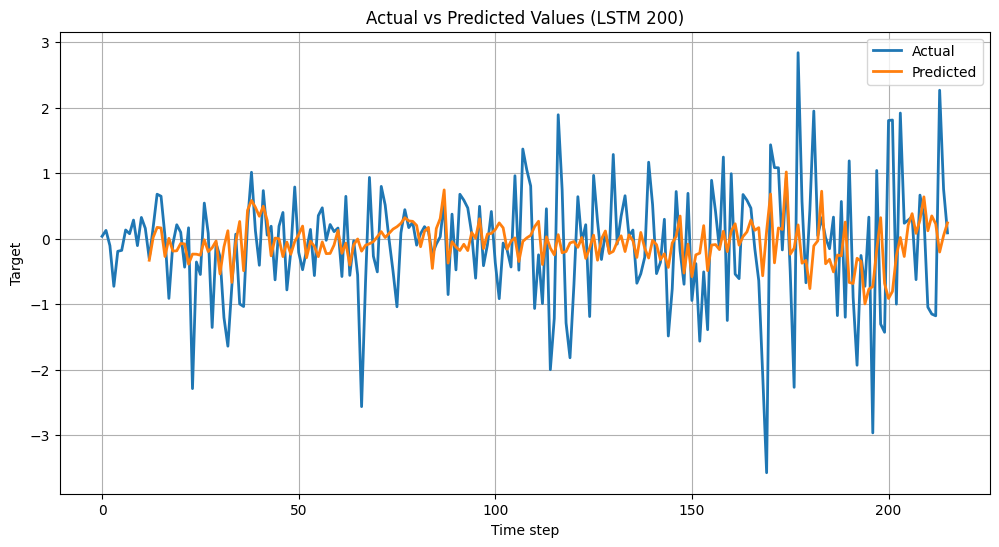

In [132]:
pred_LSTM_200_reshaped = closing_price_LSTM_200.reshape(-1, 1)

pred_aligned_LSTM_200 = np.empty_like(target_train.values)
pred_aligned_LSTM_200[:] = np.nan
# Adjust the slicing to align the predicted values correctly
pred_aligned_LSTM_200[window_size:] = pred_LSTM_200_reshaped

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_aligned_LSTM_200, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (LSTM 200)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

##ARIMA model

In [47]:
model_arim = ARIMA(endog=target_train, exog=features_train, order=(1, 2, 2))
model_arim = model_arim.fit()
pred_arim = model_arim.forecast(exog=features_test, steps=len(target_test))
mse_arim = mean_squared_error(target_test, pred_arim)
rmse_arim = mse_arim**0.5
print('The average root square error in the test sample was:', rmse_arim)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The average root square error in the test sample was: 1.8321786643140963


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


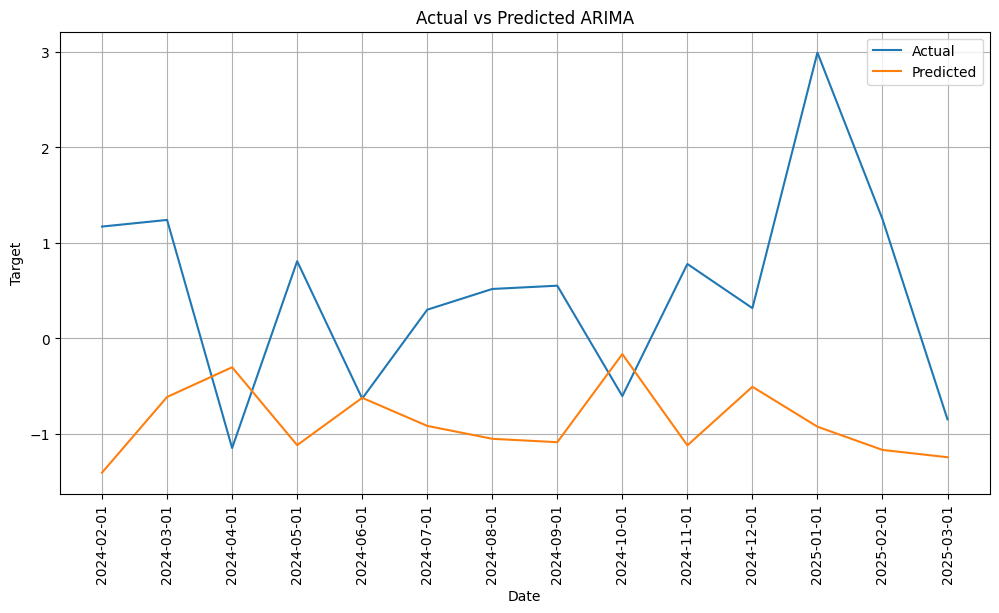

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(target_test.index, target_test.values, label='Actual')
plt.plot(target_test.index, pred_arim, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Target')
plt.xticks(rotation=90) # Rotate the x-axis tick labels
plt.title('Actual vs Predicted ARIMA')
plt.legend()
plt.grid(True)
plt.show()

# Model Testing

In [49]:
pred_xgb_test = model_xgb.predict(features_test)
pred_xgb_test_unscaled = scaler_target.inverse_transform(pred_xgb_test.reshape(-1, 1))
target_test_unscaled = scaler_target.inverse_transform(target_test.values.reshape(-1, 1))
rmse_xgb = mean_squared_error(target_test_unscaled, pred_xgb_test_unscaled)**0.5
print('The root square error in the test sample was:', rmse_xgb)

The root square error in the test sample was: 720.374532491739


In [139]:
model_LSTM_test = model_LSTM_500

closing_price_LSTM_test = model_LSTM_test.predict(scaled_features_test_win)
closing_price_LSTM_test_unscaled = scaler_target.inverse_transform(closing_price_LSTM_test.reshape(-1, 1))
rmse_LSTM_test = mean_squared_error(target_test_unscaled, closing_price_LSTM_test_unscaled)**0.5

print('The average root square error in the test sample was:', rmse_LSTM_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The average root square error in the test sample was: 766.9930786057091


Comparison to Linear Regression

In [143]:
pred_line_test = model_line.predict(features_test)
pred_line_test_unscaled = scaler_target.inverse_transform(pred_line_test.reshape(-1, 1))
rmse_line = mean_squared_error(target_test_unscaled, pred_line_test_unscaled)**0.5

print('The root square error in the test sample was:', rmse_line)

The root square error in the test sample was: 743.1234260912529


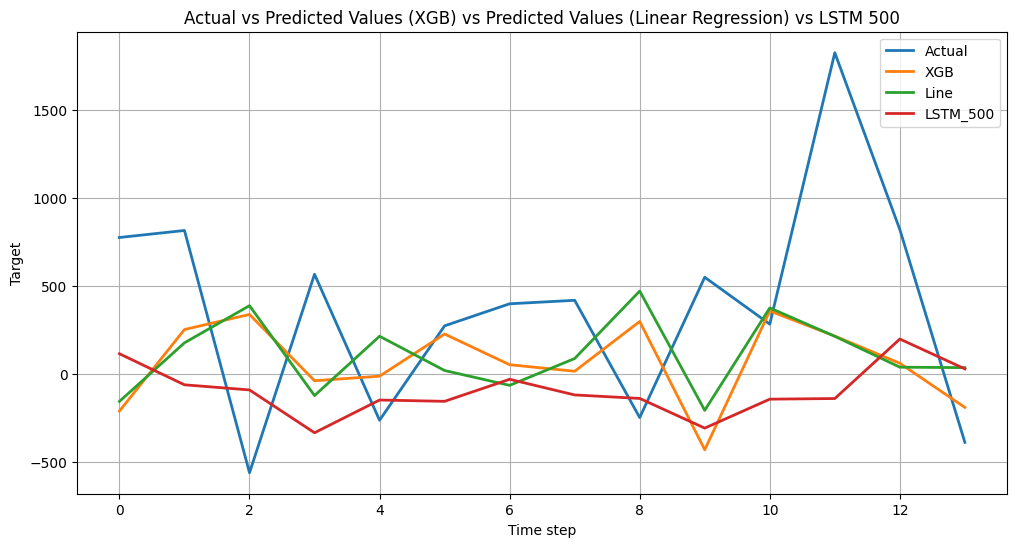

In [145]:
plt.figure(figsize=(12, 6))
plt.plot(target_test_unscaled, label='Actual', linewidth=2)
plt.plot(pred_xgb_test_unscaled, label='XGB', linewidth=2)
plt.plot(pred_line_test_unscaled, label='Line', linewidth=2)
plt.plot(closing_price_LSTM_test_unscaled, label='LSTM_500', linewidth=2)
plt.title('Actual vs Predicted Values (XGB) vs Predicted Values (Linear Regression) vs LSTM 500')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()